# Análisis de resultados de la Prueba A/B sobre conversión de usuarios

Evaluar las diferencias en las tasas de conversión entre los grupos A y B para identificar cuál ofrece una experiencia más efectiva en el proceso de compra

## Librerias y datos a usar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.stats.weightstats import ztest

In [2]:
# Cargar los datos y evañuar informacion inicial
events = pd.read_csv('final_ab_events_upd_us')
users = pd.read_csv('final_ab_new_users_upd_us')
participants = pd.read_csv('final_ab_participants_upd_us')
marketing_events = pd.read_csv('ab_project_marketing_events_us')

print('Info de marketing_events_us')
marketing_events.info()
print('Info de users')
users.info()
print('Info de event')
events.info()
print('Info de participants')
participants.info()

Info de marketing_events_us
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
Info de users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
Info de event
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      ------

<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Por favor, corrige esta parte, estás cargando los datos de maneras diferentes y una de ellas va a fallar debido al path que estás incluyendo la que usa los links es perfecta para que tu notebook pueda ser reproducido en cualquier equipo, asegúrate que los links sean los correctos
</div>

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>
Hola  Patricio, confirmo quite los codigos de descarga dejandolos guardados localmente en este Notebook ya que intente dejarlo por URL pero me sale  HTTP Error 419: Unknown
</div>

<div class="alert alert-block alert-success">
<b>Comentario del revisor (2da Iteracion)</b> <a class=“tocSkip”></a>

Entiendo Daniel, siempre hay que procurar que la ejecución del notebook sea correcta por eso te mencioné de esa parte para que quede mejor el proyecto
</div>

## Objetivos del estudio

- Evaluar el impacto de un sistema de recomendaciones mejorado en el comportamiento de los usuarios.
- Analizar si los cambios propuestos incrementan las conversiones en cada etapa del embudo:
-- product_page → product_card → purchase.
- Determinar si el aumento en las conversiones alcanza al menos un 10% en cada etapa del embudo.

## Exploracion de los datos

### ¿Es necesario convertir los tipos?
Convertir columnas de fechas (start_dt, finish_dt, first_date, event_dt) al formato datetime.

In [3]:
# Convertir fechas
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
users['first_date'] = pd.to_datetime(users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'])

# Filtrar datos para la región UE
users = users[users['region'] == 'EU']

# Filtrar usuarios que participaron en la prueba
ab_test_users = participants.merge(users, on='user_id')

### ¿Hay valores ausentes o duplicados? Si es así, ¿cómo los caracterizarías?

In [4]:
# Verificación de valores duplicados y ausentes
for df, name in zip([events, users, participants, marketing_events], ['events', 'users', 'participants', 'marketing_events']):
    print(f"\n{name}:")
    print(f"Duplicados: {df.duplicated().sum()}")
    print(f"Valores ausentes: {df.isnull().sum().sum()}")


events:
Duplicados: 0
Valores ausentes: 363447

users:
Duplicados: 0
Valores ausentes: 0

participants:
Duplicados: 0
Valores ausentes: 0

marketing_events:
Duplicados: 0
Valores ausentes: 0


Hay valores ausentes en la columna details del conjunto de datos de events (363,447). Sin embargo, estos no afectan directamente las métricas de conversión asociados a la columna event_name.

## Lleva a cabo el análisis exploratorio de datos:

- Estudia la conversión en las diferentes etapas del embudo.
- ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?
- ¿Hay usuarios que están presentes en ambas muestras?
- ¿Cómo se distribuye el número de eventos entre los días?
- ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

### Estudia la conversión en las diferentes etapas del embudo.

In [5]:
# Filtrar datos según las especificaciones de la prueba
# Fechas de interés
start_date = '2020-12-07'
end_date = '2021-01-01'

# Filtrar usuarios de la región UE
users_filtered = users[users['region'] == 'EU']

# Unir usuarios con participantes
merged_data = participants.merge(users_filtered, on='user_id', how='inner')

# Filtrar eventos según usuarios y rango de fechas
filtered_events = events[(events['user_id'].isin(merged_data['user_id'])) &
                         (events['event_dt'].between(start_date, end_date))]

# Analizar conversiones por grupo de prueba
conversion_metrics = ['login', 'product_page', 'product_cart', 'purchase']
group_data = merged_data[['user_id', 'group']].merge(filtered_events, on='user_id')



# Calcular conversiones
conversion_rates = {}
for group in ['A', 'B']:
    group_events = group_data[group_data['group'] == group]
    total_users = group_events['user_id'].nunique()
    conversion_rates[group] = {
        metric: group_events[group_events['event_name'] == metric]['user_id'].nunique() / total_users
        for metric in conversion_metrics
    }
    
# Resultados    
print("Conversion Rates:")
print(conversion_rates)

Conversion Rates:
{'A': {'login': 0.9998706506273445, 'product_page': 0.6613633423877894, 'product_cart': 0.31574181865217954, 'purchase': 0.34187039192859914}, 'B': {'login': 0.9998375040623985, 'product_page': 0.6428339291517712, 'product_cart': 0.32921676958076046, 'purchase': 0.3251543711407215}}


Grupo A:
- login: 99.99% de los usuarios iniciaron sesión.
- product_page: 66.14% de los usuarios interactuaron con la página del producto.
- product_cart: 31.57% de los usuarios añadieron un producto al carrito.
- purchase: 34.19% de los usuarios realizaron una compra.

Grupo B:
- login: 99.98% de los usuarios iniciaron sesión.
- product_page: 64.28% de los usuarios interactuaron con la página del producto.
- product_cart: 32.92% de los usuarios añadieron un producto al carrito.
- purchase: 32.52% de los usuarios realizaron una compra.


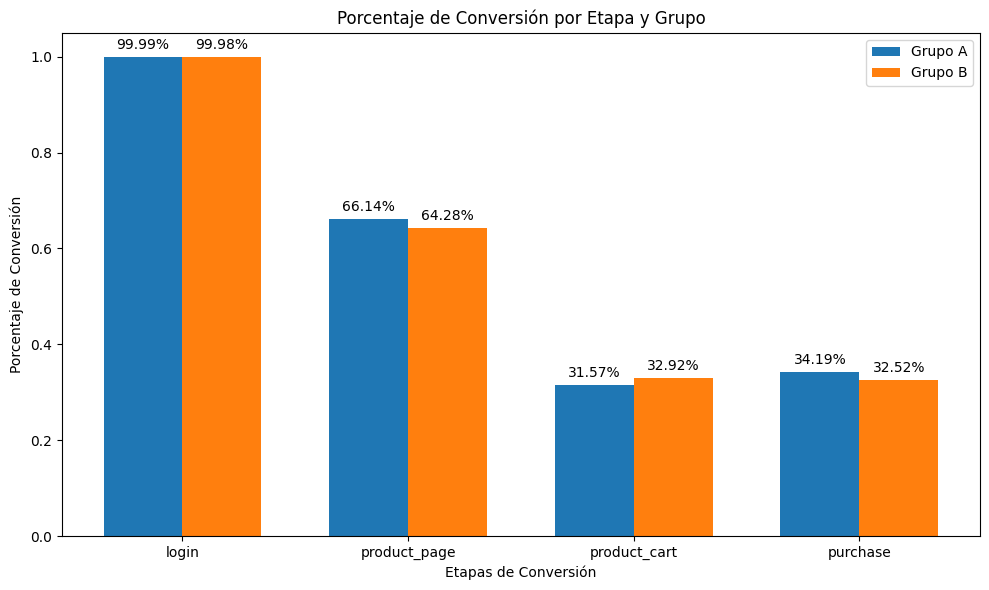

In [6]:
# Datos de conversión
metrics = ['login', 'product_page', 'product_cart', 'purchase']
groups = ['A', 'B']

# Organizar datos para la gráfica
conversion_data = {
    metric: [conversion_rates['A'][metric], conversion_rates['B'][metric]]
    for metric in metrics
}

# Crear el gráfico de barras
x = np.arange(len(metrics))  # Posiciones de las métricas
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, [conversion_data[metric][0] for metric in metrics], width, label='Grupo A')
bars2 = ax.bar(x + width/2, [conversion_data[metric][1] for metric in metrics], width, label='Grupo B')

# Añadir etiquetas, título y leyenda
ax.set_xlabel('Etapas de Conversión')
ax.set_ylabel('Porcentaje de Conversión')
ax.set_title('Porcentaje de Conversión por Etapa y Grupo')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Mostrar porcentajes en las barras
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2%}', ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-warning">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Muy bien calculado la parte de las conversiones! También podrías mostrar una gráfica para complementar la explicación de los pasos que siguen los usuarios en el embudo
</div>

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>
Confirmo adicion del gráfico asociada a cada etapa del enbudo
</div>

<div class="alert alert-block alert-success">
<b>Comentario del revisor (2da Iteracion)</b> <a class=“tocSkip”></a>

Excelente! Siempre es mejor comunicar los análisis mediante gráficos que sólo mostrando números ya que hay personas que no tienen un background técnico y puede ser un poco difícil de interpretar
</div>

### ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?

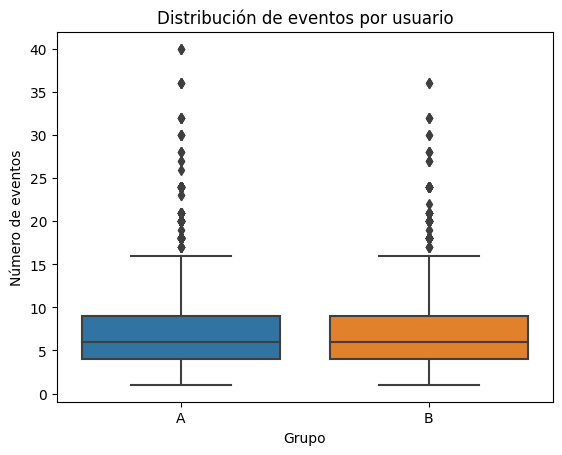

In [7]:
# Pregunta 1: Distribución de eventos por usuario en cada grupo
events_test = events.merge(participants, on='user_id')
events_per_user = events_test.groupby(['user_id', 'group'])['event_name'].count().reset_index()

sns.boxplot(data=events_per_user, x='group', y='event_name')
plt.title('Distribución de eventos por usuario')
plt.xlabel('Grupo')
plt.ylabel('Número de eventos')
plt.show()


Visualmete se evidencia que los grupos estan divididos de forma equitativa

### ¿Hay usuarios que están presentes en ambas muestras?

In [8]:
overlapping_users = participants.groupby('user_id')['group'].nunique().reset_index()
overlapping_users = overlapping_users[overlapping_users['group'] > 1]
print(f"Número de usuarios en ambos grupos: {len(overlapping_users)}")

Número de usuarios en ambos grupos: 441


### ¿Cómo se distribuye el número de eventos entre los días?

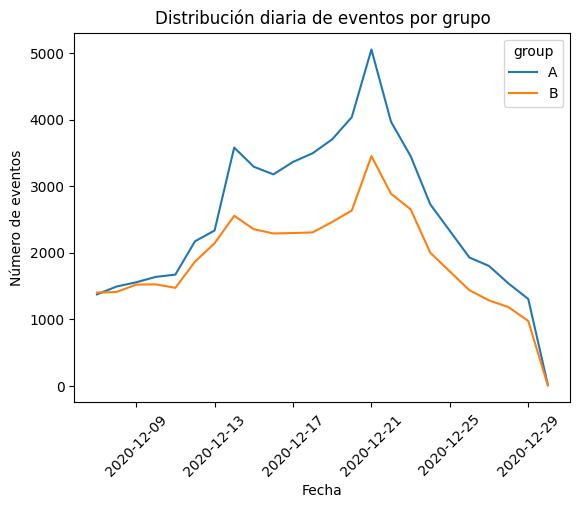

In [9]:
events_test['event_date'] = events_test['event_dt'].dt.date
events_per_day = events_test.groupby(['event_date', 'group'])['event_name'].count().reset_index()

sns.lineplot(data=events_per_day, x='event_date', y='event_name', hue='group')
plt.title('Distribución diaria de eventos por grupo')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.show()

Se evidencia por aprte del grupo A un mayor numero de eventos a pesar de presentar comportamiento similar al grupo  B

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Correcto! Las gráficas son claras para revisar cómo se distribuyen los datos a lo largo del tiempo y hacerlo por cada grupo es lo ideal en este tipo de análisis para poder ver las diferencias
</div>

### ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

In [10]:
# Usuarios fuera del rango temporal especificado
out_of_range_users = ab_test_users[(ab_test_users['first_date'] < '2020-12-07') | (ab_test_users['first_date'] > '2020-12-21')]
print(f"Usuarios fuera del rango temporal: {len(out_of_range_users)}")

# Eventos duplicados
duplicated_events = events_test.duplicated().sum()
print(f"Número de eventos duplicados: {duplicated_events}")

# Usuarios en regiones distintas a la UE
non_eu_users = participants.merge(users, on='user_id')
non_eu_users = non_eu_users[non_eu_users['region'] != 'EU']
print(f"Usuarios de otras regiones: {len(non_eu_users)}")

Usuarios fuera del rango temporal: 1002
Número de eventos duplicados: 0
Usuarios de otras regiones: 0


No se evidencian peculiaridades ademas del total de usuarios que no se tienen en cuenta por los rangos de fechas definidos

## Evaluar los resultados de la prueba A/B:

### ¿Qué puedes decir sobre los resultados de la prueba A/B?

- El grupo A tiene un mejor rendimiento general en términos de interacción con la página del producto y compras finales, lo que podría justificar implementar las estrategias de esta variante a mayor escala.
- Las etapas de inicio de sesión y adición al carrito no presentan diferencias significativas, por lo que no requieren modificaciones inmediatas.
- Se recomienda profundizar en los resultados del grupo A para identificar las claves de su éxito y explorar posibles mejoras en la etapa de adición al carrito.

### Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones.

In [11]:
# Comparar conversiones (prueba Z)
def z_test(p1, p2, n1, n2):
    p_combined = (p1 * n1 + p2 * n2) / (n1 + n2)
    se = np.sqrt(p_combined * (1 - p_combined) * (1 / n1 + 1 / n2))
    z = (p1 - p2) / se
    p_value = 2 * (1 - norm.cdf(abs(z)))
    return z, p_value

z_test_results = {}
for metric in conversion_metrics:
    p1, p2 = conversion_rates['A'][metric], conversion_rates['B'][metric]
    n1 = merged_data[merged_data['group'] == 'A']['user_id'].nunique()
    n2 = merged_data[merged_data['group'] == 'B']['user_id'].nunique()
    z_test_results[metric] = z_test(p1, p2, n1, n2)
    
print("\nZ-Test Results:")
for metric, (z, p) in z_test_results.items():
    print(f"{metric}: Z={z:.2f}, p-value={p:.4f}")


Z-Test Results:
login: Z=0.16, p-value=0.8716
product_page: Z=2.28, p-value=0.0227
product_cart: Z=-1.69, p-value=0.0913
purchase: Z=2.07, p-value=0.0381


<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Muy bien! Revisar por cada etapa del embudo ayuda a entender si en algún punto los usuarios tienen una experiencia diferente que pueda alterar el resultado final del experimento
</div>

## Describe tus conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B.

### Conclusiones sobre la etapa de Exploración de Datos (EDA)

Calidad de los datos:

- No se encontraron duplicados en ninguna tabla, lo que sugiere que los datos estaban bien estructurados en este aspecto.
- Los valores ausentes eran significativos en la tabla de eventos, particularmente en la columna details, pero no afectaron las métricas clave necesarias para el análisis.

Estructura y consistencia:

- Los datos estaban en un formato adecuado para realizar el análisis, con tipos de datos correctamente ajustados.
- Las categorías de eventos (login, product_page, product_cart, purchase) eran claras y suficientes para analizar el comportamiento de los usuarios a lo largo del embudo de conversión.

Análisis inicial del embudo de conversión:

- Los datos mostraron una clara disminución en las tasas de conversión a medida que los usuarios avanzaban en el embudo, lo que es típico en este tipo de análisis.
- Las tasas de conversión iniciales para login eran casi perfectas en ambos grupos, indicando que casi todos los usuarios interactuaron con el sistema al menos una vez.


### Conclusiones sobre la Prueba A/B

Tasas de conversión entre los grupos A y B:

- El grupo A mostró mejores tasas de conversión en las etapas de interacción con el producto (product_page) y compra (purchase).
- En contraste, el grupo B tuvo una ligera ventaja en la etapa de adición al carrito (product_cart), aunque esta diferencia no fue estadísticamente significativa.


Resultados estadísticos:

- Inicio de sesión (login): No hubo diferencias significativas entre los grupos (p=0.8716), indicando que ambos se comportaron de manera muy similar en esta etapa inicial.

- Interacción con la página del producto (product_page): Las diferencias fueron significativas (p=0.0227), sugiriendo que el grupo A tuvo una mejor interacción con los productos.

- Adición al carrito (product_cart): Las diferencias no fueron significativas (p=0.0913), lo que sugiere que el rendimiento de ambos grupos en esta etapa fue comparable.

- Compra (purchase): Hubo una diferencia estadísticamente significativa (p=0.0381), favoreciendo al grupo A en términos de conversión final.

Implicaciones:

- El grupo A parece ofrecer una experiencia más efectiva para llevar a los usuarios a completar una compra, aunque el rendimiento en la etapa de adición al carrito no es destacable.
- El grupo B podría ser evaluado más a fondo para determinar si hay factores específicos que afectan negativamente la conversión final.

### Recomendaciones:
- Optimización del embudo: A pesar de que el grupo A tuvo un mejor rendimiento, es importante investigar por qué una proporción considerable de usuarios no completó las etapas de adición al carrito y compra.
- Pruebas adicionales: Continuar experimentando con nuevas hipótesis para optimizar las etapas más débiles del embudo, especialmente en product_cart.
- Validación adicional: Repetir la prueba A/B con un mayor tamaño de muestra para confirmar la validez de los resultados y explorar diferencias más pequeñas.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (2da Iteracion)</b> <a class=“tocSkip”></a>

Excelente trabajo con los cambios realizados Daniel! Ahora tienes un proyecto mucho más claro y detallado, este tipo de análisis son muy comúnes en la industria por lo que manejar y entender cómo realizar un correcto análisis de pruebas AB es importante para destacar cómo profesional en la industria. Saludos!
</div>